# Project 2：NASA Data Acquisation, Visualization, and Analysis

In [36]:
# The code makes sure that once there is change in the 'src/' folder, the 
# change will be automatically reloaded in the notebook.
%reload_ext autoreload
%autoreload 2
%aimport src

from datetime import datetime, timedelta
from getpass import getpass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import requests
import time
from scipy import stats

from nasa_functions import *

### Task 1: Understanding the NASA API and Data Collection

- Register for a NASA API key and understand the different types of data that the API provides.
- Run the Python script below to fetch data about **Near Earth Objects (NEOs)** from the NASA API for a years data.
- Extract and understand the different pieces of data provided for each NEO.

In [2]:
# Get API key from user
api_key = getpass()

# API key (Frederik): 5moAl3aXJFGab03t4Rwyvnsb9UKRUSq5Tpu2aZYm
# API key (Nicole): KrcOIAM7hOjCyEN016pr35qkBVunND4DUBuzUXTE


# Set the start and end dates for the data you want to fetch
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')
end_date = start_date + timedelta(days=365)  # 1 year later


# Load data from NASA. 
data = get_data(api_key, start_date, end_date)


In [96]:
# Check the date there is contained in data
dates_contained_in_data = []
for d in data: dates_contained_in_data += list(d['near_earth_objects'].keys())

# Sort the dates so 2022-01-01 is first 
dates_contained_in_data = sorted(dates_contained_in_data)

# New empty dataframe
df_data = pd.DataFrame()

#Load the data from the json file to a pandas dataframe
json_to_dataframe(df_data, data, dates_contained_in_data)

df_data = df_data.apply(pd.to_numeric, errors='ignore')

# datastructure of the dataframe
df_data.head(5)    

,date,week,id,neo_reference_id,name,nasa_jpl_url,absolute_magnitude_h,kilometers estimated_diameter_min,kilometers estimated_diameter_max,meters estimated_diameter_min,...,epoch_date_close_approach,relative_velocity kilometers_per_second,relative_velocity kilometers_per_hour,relative_velocity miles_per_hour,miss_distance astronomical,miss_distance lunar,miss_distance kilometers,miss_distance miles,orbiting_body,is_sentry_object
11,2022-01-01,0.0,2363505,2363505,363505 (2003 UC20),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2363505,18.52,0.525479,1.175006,525.478530,...,1.641000e+12,12.518531,45066.713121,28002.702939,0.157698,61.344390,2.359123e+07,1.465891e+07,Earth,False
12,2022-01-01,0.0,2376848,2376848,376848 (2001 RY47),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2376848,19.61,0.318094,0.711279,318.093633,...,1.641072e+12,17.701016,63723.656796,39595.402191,0.342086,133.071640,5.117541e+07,3.179892e+07,Earth,False
13,2022-01-01,0.0,2488490,2488490,488490 (2000 AF205),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2488490,21.90,0.110804,0.247765,110.803882,...,1.641052e+12,21.077399,75878.637808,47148.034698,0.407186,158.395382,6.091417e+07,3.785031e+07,Earth,False
14,2022-01-01,0.0,3388081,3388081,(2007 TL23),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3388081,21.48,0.134448,0.300635,134.448195,...,1.641059e+12,31.100974,111963.505363,69569.768096,0.197682,76.898348,2.957283e+07,1.837570e+07,Earth,False
15,2022-01-01,0.0,3592308,3592308,(2012 AP10),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3592308,26.50,0.013322,0.029788,13.321557,...,1.641063e+12,15.995934,57585.362913,35781.305083,0.397118,154.478962,5.940803e+07,3.691444e+07,Earth,False


For the remaining tasks, you have to organize the data as pd.DataFrame so as to suit the specific need in each task. This part may require a considerably amount of efforts, which is normal in data science and analytics works.

### Task 2: Data Analysis

- Calculate the average size of the NEOs for each day.
- Determine the proportion of NEOs that are potentially hazardous.
- Find the NEO with the closest approach distance for each day.
- Use statistical methods to analyze the data. For example, calculate the mean, median, mode, and standard deviation of the NEO sizes. Determine if the size of a NEO is correlated with whether it is potentially hazardous.

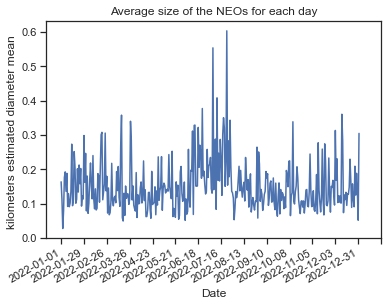

In [97]:
#### Average size of the NEOs for each day ####

# Size is the mean of estimated_diameter_min and estimated_diameter_max
df_data.loc[:, 'kilometers estimated_diameter_mean']=(df_data['kilometers estimated_diameter_min']+df_data['kilometers estimated_diameter_max'])/2
df_NEO_size_day_mean = df_data.groupby('date')['kilometers estimated_diameter_mean'].mean()

plt.plot(df_NEO_size_day_mean.index, df_NEO_size_day_mean)
plt.xticks(rotation=30, ha='right', ticks=np.arange(0,418,28))
plt.xlabel('Date')
plt.ylabel('kilometers estimated diameter mean ')
plt.title('Average size of the NEOs for each day')
plt.show()

In [92]:
#### Proportion of NEOs that are potentially hazardous ####

# Get the status of the NEOs for each day
hazardous = list(df_data['is_potentially_hazardous_asteroid'])

# Count true and false values
true_count = hazardous.count(True)
false_count = hazardous.count(False)

# calculate the proportion
print('True counts: ',true_count)
print('False counts: ',false_count)
print('procent true: ',(true_count/(true_count+false_count))*100)




True counts:  507
False counts:  7444
procent true:  6.3765564079989945


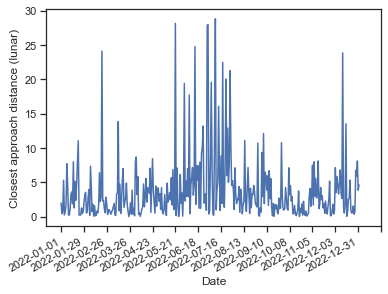

In [123]:

#### NEO with the closest approach distance for each day ####
df_dis_lunar_min = df_data.groupby('date')['miss_distance lunar'].min().astype('float')

plt.plot(df_dis_lunar_min.index, df_dis_lunar_min)
plt.xticks(rotation=30, ha='right', ticks=np.arange(0,418,28))
plt.xlabel('Date')
plt.ylabel('Closest approach distance (lunar)')
plt.show()



In [7]:
#Descriptive statistics
df_data.describe()

,week,absolute_magnitude_h,kilometers estimated_diameter_min,kilometers estimated_diameter_max,meters estimated_diameter_min,meters estimated_diameter_max,miles estimated_diameter_min,miles estimated_diameter_max,feet estimated_diameter_min,feet estimated_diameter_max,epoch_date_close_approach,kilometers estimated_diameter_mean
count,7951.000000,7951.000000,7951.000000,7951.000000,7951.000000,7951.000000,7951.000000,7951.000000,7951.000000,7951.000000,7.951000e+03,7951.000000
mean,26.500440,24.157607,0.092983,0.207916,92.982919,207.916127,0.057777,0.129193,305.062079,682.139547,1.657368e+12,0.150450
std,15.342266,2.731514,0.182580,0.408262,182.580165,408.261660,0.113450,0.253682,599.016308,1339.441183,9.280005e+09,0.295421
min,0.000000,14.680000,0.000683,0.001528,0.683211,1.527707,0.000425,0.000949,2.241507,5.012161,1.641000e+12,0.001105
25%,13.000000,22.300000,0.016016,0.035813,16.016034,35.812940,0.009952,0.022253,52.546044,117.496527,1.648916e+12,0.025914
50%,28.000000,24.450000,0.034242,0.076567,34.241673,76.566709,0.021277,0.047576,112.341451,251.203121,1.658022e+12,0.055404
75%,40.000000,26.100000,0.092163,0.206082,92.162655,206.081961,0.057267,0.128053,302.370925,676.121942,1.665740e+12,0.149122
max,52.000000,32.950000,3.080030,6.887157,3080.030213,6887.156928,1.913841,4.279480,10105.086323,22595.659937,1.672615e+12,4.983594


In [107]:
df_data.groupby('is_potentially_hazardous_asteroid')['kilometers estimated_diameter_mean'].mean()

is_potentially_hazardous_asteroid
False    0.130653
True     0.441109
Name: kilometers estimated_diameter_mean, dtype: float64

In [109]:
df_data.groupby('is_potentially_hazardous_asteroid')['kilometers estimated_diameter_mean'].var()

is_potentially_hazardous_asteroid
False    0.077105
True     0.146607
Name: kilometers estimated_diameter_mean, dtype: float64

### Task 3: Data Visualization Part A

- Create a line plot of the number of NEOs per week.
- Create a histogram of the distribution of NEO sizes.
- Create a bar plot of the average NEO size per week.
- Use a library like Seaborn to create more complex visualizations, such as a box plot of the NEO sizes or a heat map of the number of NEOs per week. **Be creative**!

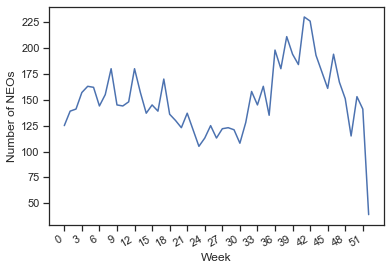

In [106]:
#### Create a line plot of the number of NEOs per week ####

df_NEO_week_number = df_data.groupby('week')['date'].count()

plt.plot(df_NEO_week_number.index, df_NEO_week_number)
plt.xticks(rotation=30, ha='right', ticks=np.arange(0,54,3))
plt.xlabel('Week')
plt.ylabel('Number of NEOs')
plt.show()

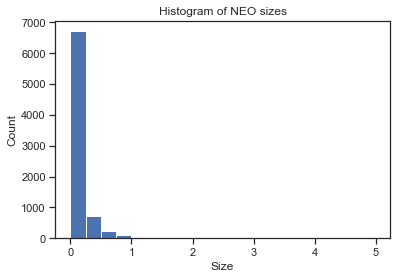

In [124]:
#### Create a histogram of the distribution of NEO sizes #### 

plt.hist(df_data['kilometers estimated_diameter_mean'],bins=20)
plt.title('Histogram of NEO sizes')
plt.xlabel('Size')
plt.ylabel('Count')
plt.show()

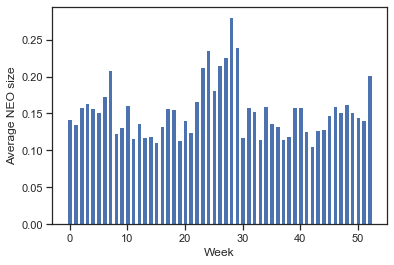

In [104]:
#Create a bar plot of the average NEO size per week.

df_NEO_size_week_mean = df_data.groupby('week')['kilometers estimated_diameter_mean'].mean()

plt.bar(df_NEO_size_week_mean.index, df_NEO_size_week_mean)
plt.xlabel('Week')
plt.ylabel('Average NEO size')
plt.show()

<AxesSubplot:xlabel='kilometers estimated_diameter_mean'>

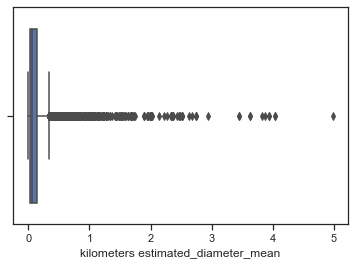

In [111]:
#Use a library like Seaborn to create more complex visualizations, such as a box plot of the NEO sizes or a heat map of the number of NEOs per week.

sns.boxplot(x=df_data['kilometers estimated_diameter_mean'])

<AxesSubplot:xlabel='kilometers estimated_diameter_mean'>

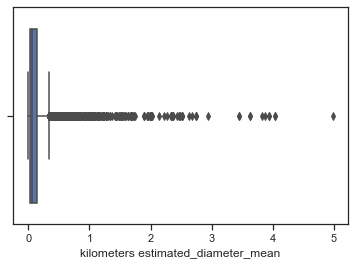

In [125]:
sns.boxplot(x=df_data['kilometers estimated_diameter_mean'],showfliers = False)

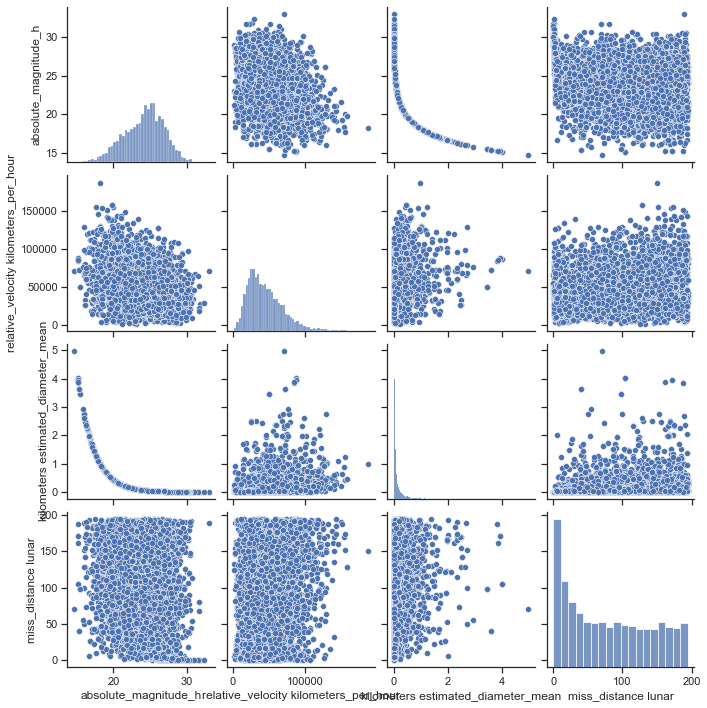

In [115]:

col = ['absolute_magnitude_h','relative_velocity kilometers_per_hour','kilometers estimated_diameter_mean', 'miss_distance lunar']

sns.pairplot(df_data,vars=col)

### Task 4: Data Visualization Part B

- Create a pie chart of the proportion of hazardous vs non-hazardous NEOs.
- Create a scatter plot of the correlation between NEO size and close approach distance.
- Customize the appearance of your plots (e.g., colors, labels, titles).
- Create interactive visualizations using a library like Plotly. For example, create an interactive scatter plot where you can hover over each point to see more information about the NEO. **Be creative!**

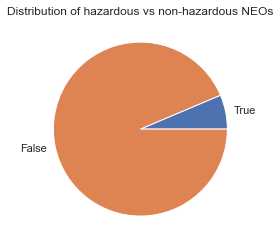

In [14]:
#  Pie chart of the proportion of hazardous vs non-hazardous NEOs.
labels = ['True', 'False']
counts = [true_count, false_count]

plt.figure(facecolor='white')
plt.pie(counts, labels = labels)
plt.title('Distribution of hazardous vs non-hazardous NEOs')
plt.show() 

[Text(0.5, 1.0, 'Scatter plot of the correlation')]

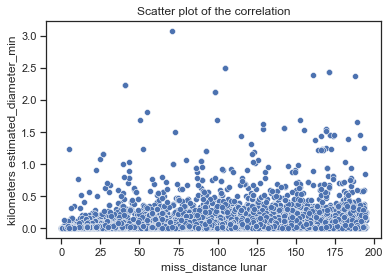

In [101]:
#### Scatter plot of the correlation between NEO size and close approach distance ###


sns.scatterplot(x="miss_distance lunar",y="kilometers estimated_diameter_min",data=df_data).set(title='Scatter plot of the correlation')



In [99]:
# Interactive visualizations

import plotly.express as px

fig = px.line( y=df_NEO_size_day_mean, x=df_NEO_size_day_mean.index,title='Size')
fig.show()



In [100]:

fig = px.line( y=df_dis_lunar_min, x=df_dis_lunar_min.index,title='Miss distance (lunar)')
fig.show()

### Task 5: Interpretation of Results

- Interpret the results of your data visualization in part A and B. 
- What insights can you gain about NEOs from your results? Summarizing your findings.
- Use your findings to make predictions or recommendations. For example, if you found that larger NEOs are more likely to be potentially hazardous, you could recommend that more resources be allocated to tracking large NEOs. **Be creative!**
- Identify, understand, and explain one scientific paper, on a clustering or classification method of relevance that could help Task 5. You don't have to implement it, you just need to justify in this notebook why the method in the scientific paper could contribute in analysis or interpretation of the results.

In [18]:
# Write your code

# New insights

- The average NEO size is higher over the summer period. 
- The average NEO size is really high over the summer. 
- The number of NEOs decrease over the sommer and is high in the fall.




# Scientific paper

Link to paper: https://www.researchgate.net/publication/285663733_Data_classification_using_support_vector_machine

The paper is about the support vector machine (SVM) used for classification. SVM is supervised learning algorithm for classification and regression and SVM can be used for high-dimensional data. First, the SVM maps the input to high dimensional space and then tries to find the hyperplane that separates the data the best. 



- First, we will make a PCA analysis on all the features to only get the significant components.
- Then will use the features to train a classifier using the support vector machine.
- We will use cross validation to find the optimal parameter setting when training the classifier.
- In the end, we have a classier that can classify if the NEO is hazardous or non-hazardous based on the selected features from the PCA analysis.






### Task 6: Presentation and Documentation

- Make this project as part of your presentation, **using beamer in LaTeX**. 
- This should include an overview of your work, the results of your data analysis, and the insights you gained from your results.